# Applying LSTM for Sentiment Analysis of IMDB Movie Reviews



This dataset has 50K movie reviews fetched from the IMDB website.
This is a dataset for binary sentiment classification. Our objective is to predict the number of positive and negative reviews using either classification or deep learning algorithms like LSTM recurrent neural networks.
We develop sequential LSTM neural network with embedding, spatial dropout, LSTM layers, and dense layers for sequence tasks, handling sequences of length 250 and utilizing around 5 million parameters. 

Dataset: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

## Libraries

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc


## Load Dataset

In [10]:
# Load the dataset
data = pd.read_csv('IMDB_Dataset.csv')

# Text preprocessing
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text
data['review'] = data['review'].apply(clean_text)

## Tokenization and Sequence Padding

In [11]:
# Tokenization and sequence padding
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['review'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(data['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)



Shape of data tensor: (50000, 250)


## Prepare Labels and split data in training and testing sets

In [12]:
# Prepare labels and split the data
Y = pd.get_dummies(data['sentiment']).values
print('Shape of data tensor', Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of data tensor (50000, 2)
(40000, 250) (40000, 2)
(10000, 250) (10000, 2)


We convert the categorical labels into numerical form using one-hot encoding and then split our data into a training set and a testing set.



## Define and Train Model

In [13]:
# Define and train the model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_3 (Spati  (None, 250, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 5080602 (19.38 MB)
Trainable params: 5080602 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
563/563 [==============================] - 774s 1s/step - loss: 0

In [14]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_3 (Spati  (None, 250, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 5080602 (19.38 MB)
Trainable params: 5080602 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Plotting curves

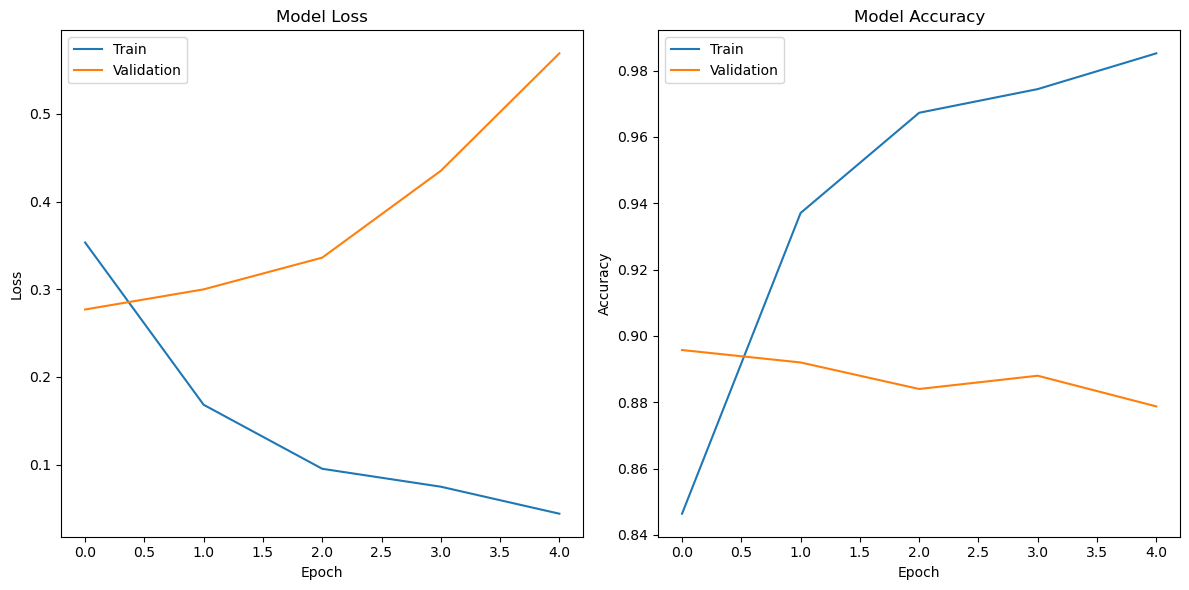

313/313 [==============================] - 35s 109ms/step


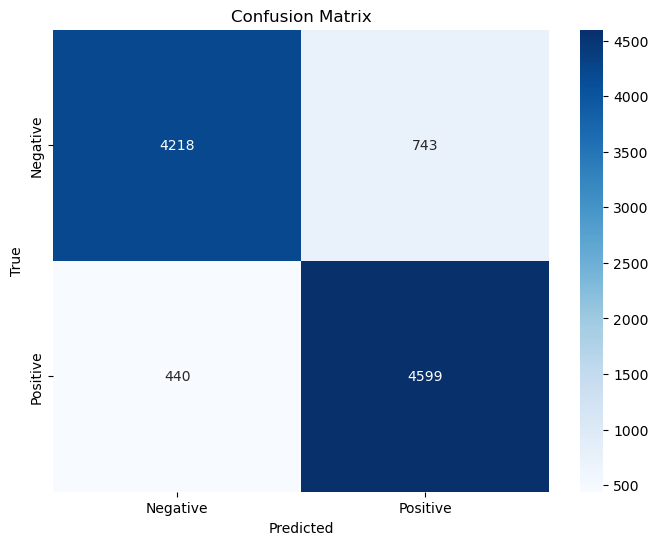

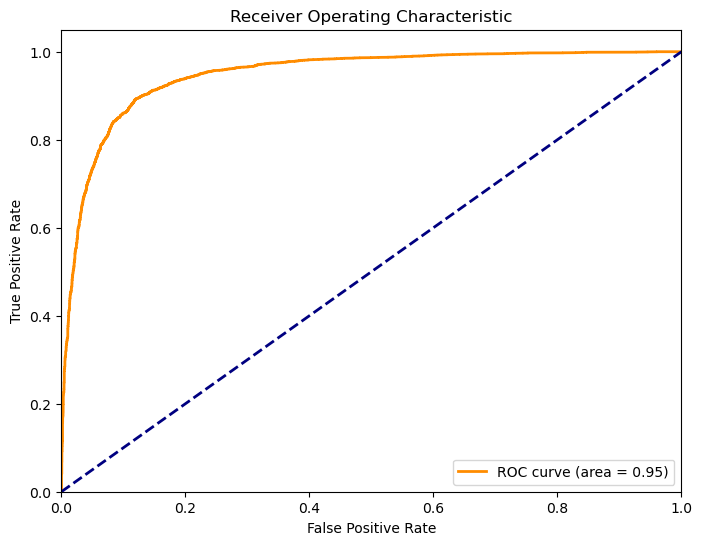

In [15]:
# Plot training progress
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Get model predictions
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_true, Y_pred[:, 1])
roc_auc = auc(fpr, tpr)



# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [16]:
from sklearn.metrics import roc_auc_score

# Calculate AUC-ROC score
roc_auc = roc_auc_score(Y_true, Y_pred[:, 1])
print(f'AUC-ROC Score: {roc_auc:.3f}')


AUC-ROC Score: 0.947


## Validate the model

In [17]:
# Validate the model
accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))

313/313 [==============================] - 37s 117ms/step - loss: 0.5206 - accuracy: 0.8817
Test set
  Loss: 0.521
  Accuracy: 0.882


The final model achieves an accuracy of approximately 88.2% on the test set.